In [1]:
import datetime as dt
import json
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv(override=True)

PATH = os.environ.get("PATH_RAW_DATA")
TICKER = os.environ.get("TICKER")


In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras

## Load the data

Already downloaded using src/utils/fetchStockData

In [3]:
PATH_RAW_DATA = f"data/data-BTC.json"
PATH_RAW_DATA_CSV = "data/data-BTC.csv"
print(f"Looking for {TICKER}")

if not os.path.exists(PATH_RAW_DATA_CSV):
  f = open(PATH_RAW_DATA)
  data = json.load(f)
  data = data['Data']["Data"]
  df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
  for v in data:
    date = dt.datetime.utcfromtimestamp(v["time"]).strftime('%Y-%m-%d')
    data_row = [date,float(v['low']),float(v['high']),
                float(v['close']),float(v['open'])]
    df.loc[-1,:] = data_row
    df.index = df.index + 1
  print('Data saved to : %s'%PATH_RAW_DATA_CSV)        
  df.to_csv(PATH_RAW_DATA_CSV)

# If the data is already there, just load it from the CSV
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(PATH_RAW_DATA_CSV)

Looking for BTC
File already exists. Loading data from CSV


## Daily Closing price of Bitcoin over the past 5 years

In [4]:
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
0,1825,2017-04-07,1173.18,1201.23,1190.49,1188.70
1,1824,2017-04-08,1166.65,1198.22,1180.78,1190.49
2,1823,2017-04-09,1173.99,1215.10,1204.34,1180.78
3,1822,2017-04-10,1194.81,1214.87,1206.71,1204.34
4,1821,2017-04-11,1195.76,1229.57,1220.74,1206.71


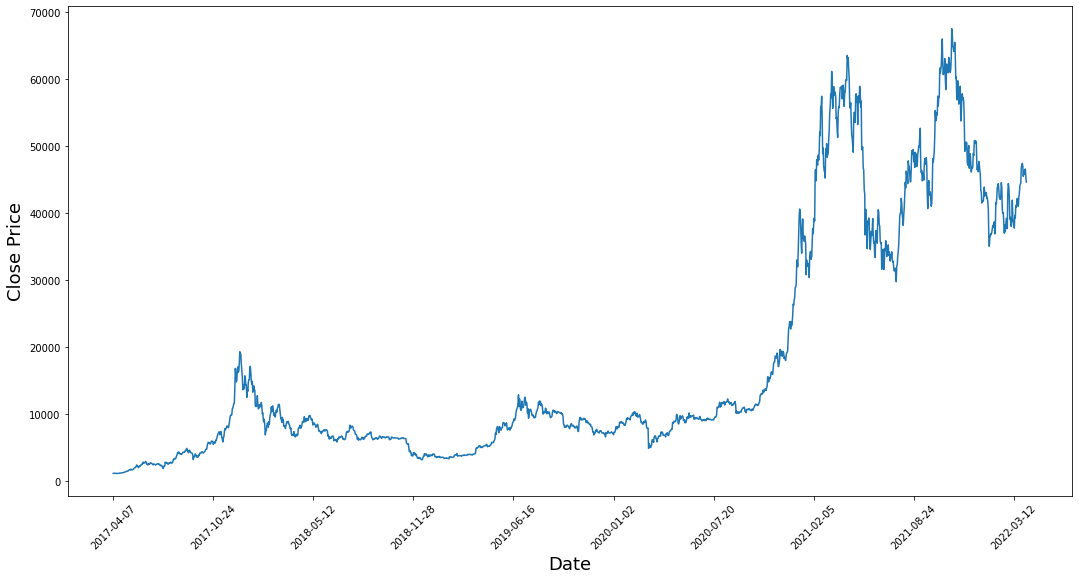

In [5]:
def show_data(df):
  plt.figure(figsize = (18,9))
  plt.plot(range(df.shape[0]), df['Close'])
  plt.xticks(range(0,df.shape[0],200),df['Date'].loc[::200],rotation=45)
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('Close Price',fontsize=18)
  plt.show()

show_data(df)

## Preprocessing

Preparing the data 

In [6]:
train_test_split = int(len(df.iloc[:])*0.8)
train_data = df.iloc[:train_test_split]
test_data = df.iloc[train_test_split:]

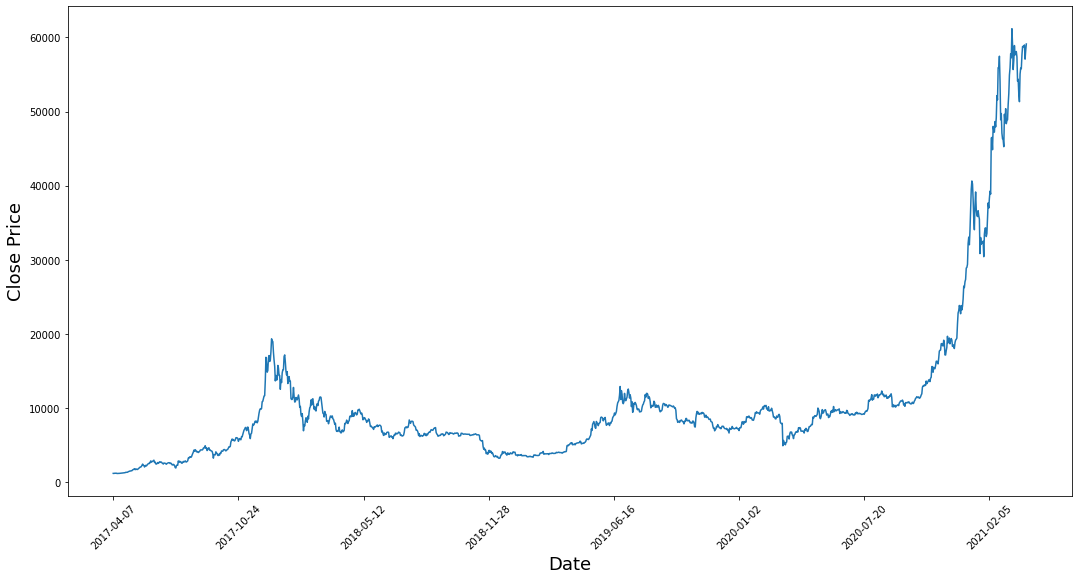

In [7]:
show_data(train_data)

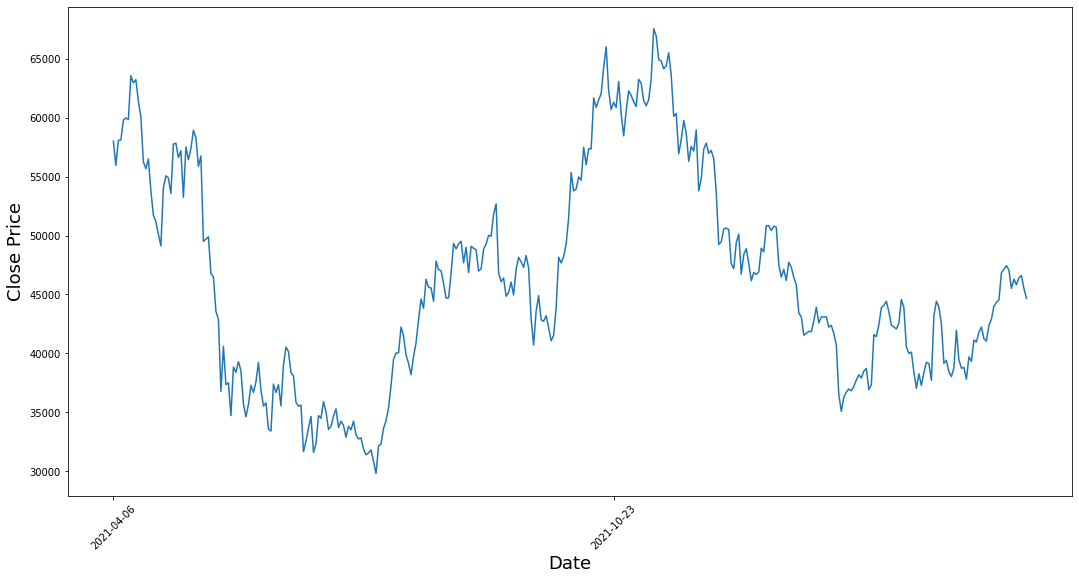

In [8]:
show_data(test_data)

In [9]:
scaler = MinMaxScaler()
train_data = np.array(train_data.loc[:, "Close"]).reshape(-1,1)
test_data = np.array(test_data.loc[:, "Close"]).reshape(-1,1)

In [10]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 365
for di in range(0,int(train_test_split/smoothing_window_size),smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [11]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [12]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
# EMA = 0.0
# gamma = 0.1
# for ti in range(train_test_split):
#   EMA = gamma*train_data[ti] + (1-gamma)*EMA
#   train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## Moving Averages: SMA and EMA

Setting the baseline for the future model with moving averages techniques

In [13]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    date = df.loc[pred_idx,'Date']
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00072


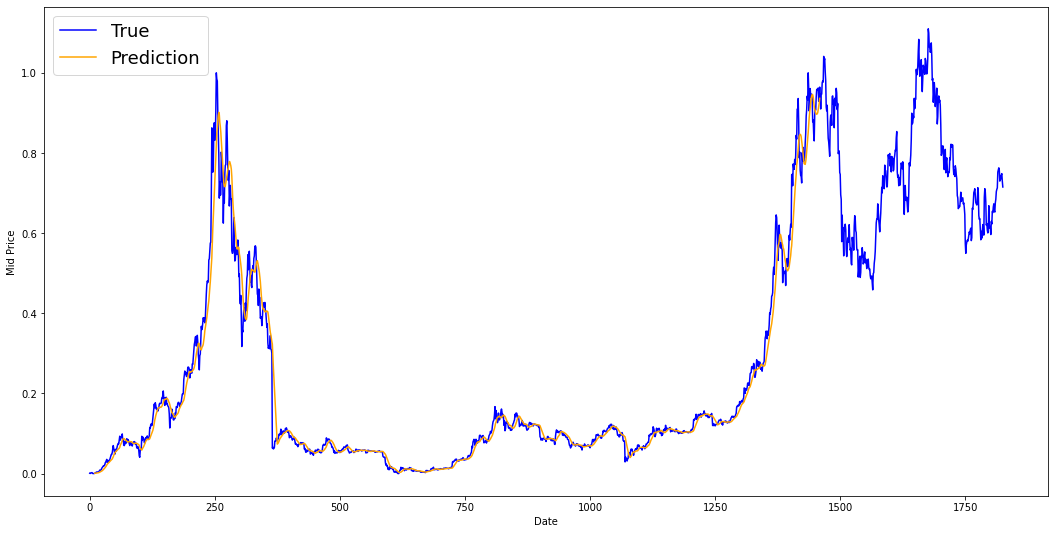

In [14]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
# plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [15]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00024


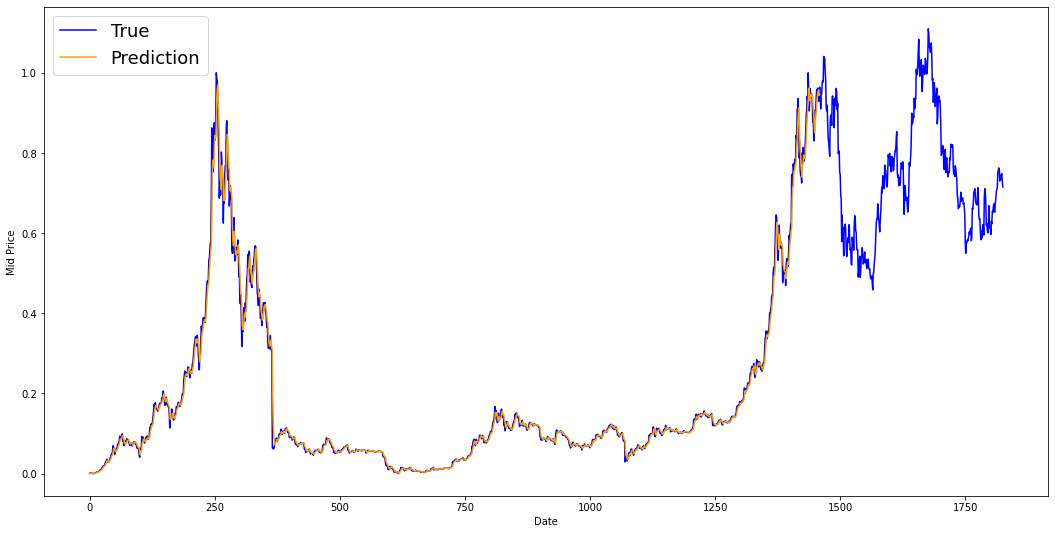

In [16]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]  
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [18]:
print(test_data.shape)
print(train_data.shape)

(366,)
(1460,)


In [19]:
# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)
# # reshape input to be [samples, time steps, features] which is required for LSTM
# X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
# print("X_train: ", X_train.shape)
# print("X_test: ", X_test.shape)

In [20]:
# model = Sequential()
# # Adding a LSTM layer with 10 internal units
# model.add(LSTM(100,input_shape=(None,1),activation='relu'))
# # Adding a Dense layer with 1 units.
# model.add(Dense(1))
# # Loss function + optimizer
# model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
# history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=10,verbose=1)

In [22]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(len(loss))
# plt.plot(epochs, loss, 'r', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend(loc=0)
# plt.figure()
# plt.show()

In [23]:
# train_predict=model.predict(X_train)
# test_predict=model.predict(X_test)
# look_back=time_step

# all_predicted_data = np.concatenate([train_predict,test_predict],axis=0)

# all_predicted_data = np.concatenate([all_mid_data[:time_step], all_predicted_data.reshape(-1)])

# plt.figure(figsize = (18,9))
# plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
# plt.plot(range(all_predicted_data.shape[0]),all_predicted_data,color='orange', label='Prediction')
# #plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend(fontsize=18)
# plt.show()

# # trainPredictPlot = np.empty_like(df["Close"])
# # trainPredictPlot[:, :] = np.nan
# # trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

In [24]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 
# choose a number of time steps
n_steps_in, n_steps_out = 90, 7
# split into samples
X, y = split_sequence(train_data, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
results = model.fit(X, y, epochs=50, verbose=1)

2022-04-22 17:12:42.209859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
43/43 [==============================] - 9s 139ms/step - loss: 0.0127
Epoch 2/50
43/43 [==============================] - 5s 117ms/step - loss: 0.0038
Epoch 3/50
43/43 [==============================] - 5s 112ms/step - loss: 0.0033
Epoch 4/50
43/43 [==============================] - 6s 133ms/step - loss: 0.0030
Epoch 5/50
43/43 [==============================] - 5s 112ms/step - loss: 0.0028
Epoch 6/50
43/43 [==============================] - 4s 88ms/step - loss: 0.0026
Epoch 7/50
43/43 [==============================] - 4s 88ms/step - loss: 0.0025
Epoch 8/50
43/43 [==============================] - 4s 90ms/step - loss: 0.0025
Epoch 9/50
43/43 [==============================] - 4s 92ms/step - loss: 0.0021
Epoch 10/50
43/43 [==============================] - 4s 97ms/step - loss: 0.0022
Epoch 11/50
43/43 [==============================] - 4s 104ms/step - loss: 0.0020
Epoch 12/50
43/43 [==============================] - 5s 123ms/step - loss: 0.0020
Epoch 13/50
43/43 [===========

In [25]:
# demonstrate prediction
x_input = test_data[-97:-7]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[0.7584535  0.78114545 0.7665822  0.7733058  0.7902176  0.79714656
  0.7857167 ]]


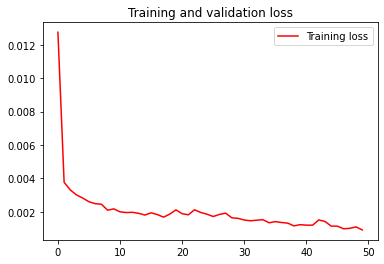

<Figure size 432x288 with 0 Axes>

In [26]:
loss = results.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

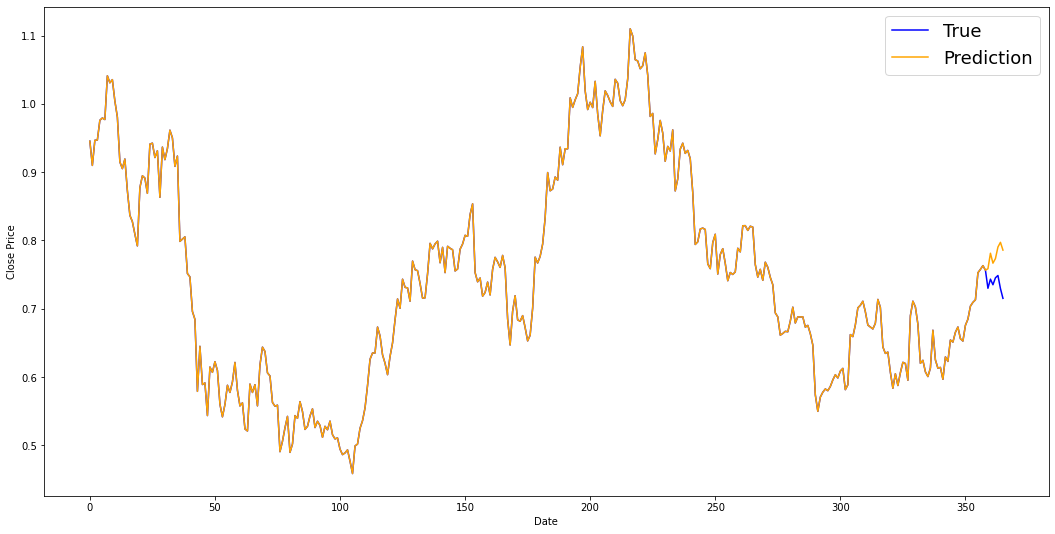

In [27]:
plt.figure(figsize = (18,9))
plt.plot(range(test_data.shape[0]),test_data,color='b',label='True')
plt.plot(range(test_data.shape[0]),np.concatenate([test_data[:-7],yhat.reshape(-1)]),color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()